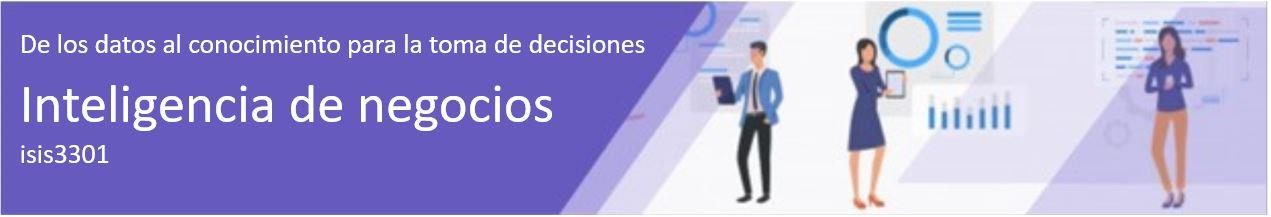

# Laboratorio 2 - Tarea de agrupación

- ### Estudiante 1: Juan Felipe Camelo
- ### Estudiante 2: Mauricio Urrego Vásquez
- ### Estudiante 3: Hernán Ramírez


En este notebook se desarrolla un proyecto de analítica de datos para SenecaféAlpes. A partir de un conjunto de datos con atributos morfológicos de granos de café, se implementará la metodología CRISP-ML para construir y evaluar modelos de agrupación. El objetivo principal es identificar patrones naturales entre siete variedades registradas de café, aplicando algoritmos como K-Means y otras alternativas de clustering. Los resultados se validarán tanto de forma cuantitativa, como cualitativa, a través de la interpretación de los grupos encontrados en relación con los objetivos estratégicos de la organización.


Este notebook se encuentra dividido en las siguientes secciones:

1. Preparación de datos
2. Modelos
   1. K-Means
   2. DBSCAN
   3. TBA
4. Modelo recomendado

# 1. Preparación de datos
## 1.1 Carga de librerías

In [220]:
import pandas as pd
import numpy as np
import sys
import os
import os.path as osp
import joblib

from sklearn.preprocessing import RobustScaler, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA, IncrementalPCA
from sklearn.metrics import silhouette_score, silhouette_samples, rand_score
from sklearn.impute import SimpleImputer

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

## 1.2 Cargar los datos

In [221]:
# Se cargan los datos. 
df = pd.read_csv('Datos_SenecaféAlpes.csv', sep=';', encoding = "ISO-8859-1")

## 1.3 Perfilamiento de datos

In [222]:
df.shape

(14291, 19)

In [223]:
df.head()

,ï»¿ID,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,DefectoVisible,MÃ©todoSecado
0,G006149,50836,923618.0,358.515147,181.388899,alargado,NaN,NaN,254.413847,0.804762,0.983840,0.748853,0.709632,0.007052,0.001103,0.503578,0.995321,Normal,Lavado
1,G007234,62764,1003767.0,409.207082,198.330199,Alargado,NaN,64158.0,282.689948,0.703995,0.978272,0.782807,0.690824,0.006520,0.000916,0.477237,0.984666,NaN,Natural
2,G007054,59965,994266.0,389.088529,197.967275,Alargado,0.860886,60910.0,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,Normal,Natural
3,G006619,55035,917.6,379.346822,185.390577,Alargado,0.872446,55591.0,NaN,0.799695,0.989998,0.821376,0.697811,0.006893,0.001008,0.486941,0.996380,Normal,Lavado
4,G013353,39324,737773.0,262.520242,191.176858,Alargado,0.685326,39758.0,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,Normal,Lavado


In [224]:
df = df.rename(columns={'MÃ©todoSecado': 'MetodoSecado'})

In [225]:
# Revisar las características de los datos: completitud y tipo de dato
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14291 entries, 0 to 14290
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ï»¿ID                14291 non-null  object 
 1   Area                 14291 non-null  int64  
 2   Perimetro            13054 non-null  float64
 3   LongitudEjeMayor     13890 non-null  float64
 4   LongitudEjeMenor     14291 non-null  float64
 5   RelacionAspecto      13825 non-null  object 
 6   Excentricidad        13687 non-null  float64
 7   AreaConvexa          12868 non-null  float64
 8   DiametroEquivalente  12368 non-null  float64
 9   Medida               14291 non-null  float64
 10  Solidez              11985 non-null  float64
 11  Redondez             12228 non-null  float64
 12  Compacidad           13641 non-null  float64
 13  FactorForma1         13172 non-null  float64
 14  FactorForma2         13185 non-null  float64
 15  FactorForma3         13813 non-null 

In [226]:
df = df.drop_duplicates()

In [227]:
# Resumen de los estadisticos de las variables numéricas
df.describe()

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4
count,13830.000000,1.263300e+04,13442.000000,13830.000000,13248.000000,12449.000000,11978.000000,13830.000000,11612.000000,11823.000000,13197.000000,12743.000000,12763.000000,13370.000000,12707.000000
mean,52987.376283,7.718237e+05,319.766440,202.085824,0.749921,53521.754117,252.859008,0.749693,0.986761,0.873054,0.799310,0.006561,0.001713,0.643265,0.994272
std,29289.506819,3.267745e+05,86.155610,45.380543,0.099587,29472.383075,60.409029,0.050768,0.026347,0.063421,0.067767,0.001164,0.000601,0.100767,0.039720
min,-62716.000000,-1.012143e+06,-421.444657,-200.838672,-0.835004,-78423.000000,-448.402605,-0.798706,-0.989042,-0.896861,-0.843901,-0.007982,-0.002673,-0.683269,-0.998527
25%,36340.750000,6.767770e+05,253.299100,175.835899,0.715508,36721.000000,215.298027,0.718653,0.985596,0.832776,0.762160,0.005903,0.001153,0.581195,0.993680
50%,44642.000000,7.718790e+05,296.485040,192.409413,0.764180,45091.000000,238.544800,0.759942,0.988280,0.883433,0.801157,0.006647,0.001693,0.641928,0.996380
75%,61259.250000,9.543480e+05,376.459017,216.804297,0.810428,62087.000000,279.453871,0.786893,0.989989,0.916817,0.834367,0.007274,0.002169,0.696228,0.997889
max,254616.000000,1.921685e+06,738.860154,460.198497,0.911423,251082.000000,569.374358,0.866195,0.994378,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


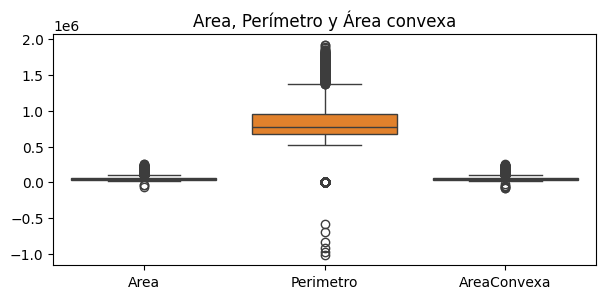

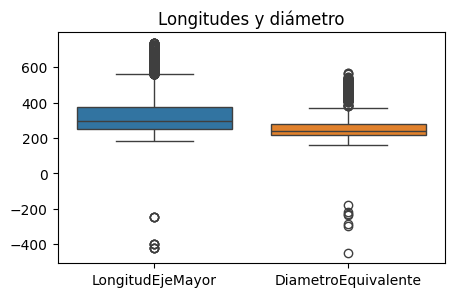

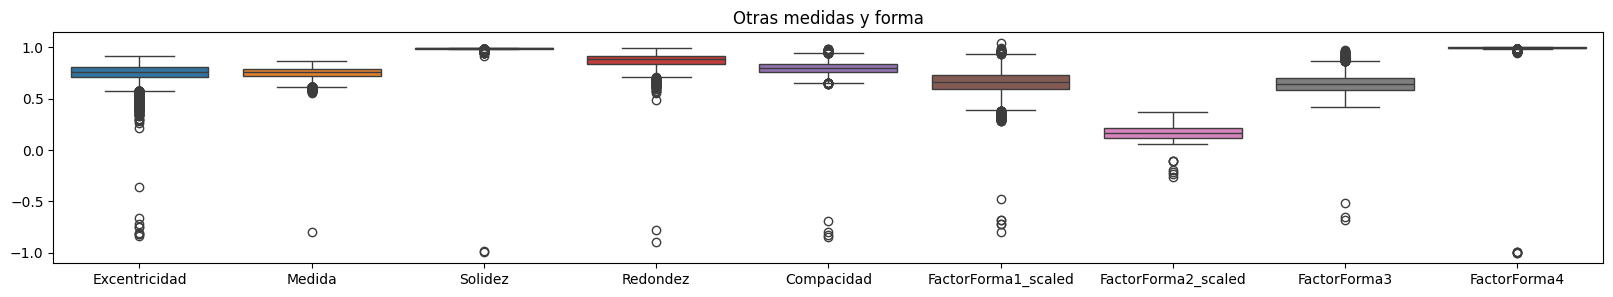

In [228]:
# Visualización de todas las variables numéricas

# graficamos por variables con dimensiones similares
# Area, Perímetro, Área convexa
fig=plt.figure(figsize=(7,3))
ax = sns.boxplot(data=df[["Area", "Perimetro", "AreaConvexa"]], orient="v")
plt.title("Area, Perímetro y Área convexa")
plt.show()

# LongitudEjes, Diámetros
fig=plt.figure(figsize=(5,3))
ax2 = sns.boxplot(data=df[["LongitudEjeMayor", "LongitudEjeMayor", "DiametroEquivalente"]], orient="v")
plt.title("Longitudes y diámetro")
plt.show()

# otras medidas y forma
df["FactorForma1_scaled"] = df["FactorForma1"]*100
df["FactorForma2_scaled"] = df["FactorForma2"]*100
fig=plt.figure(figsize=(20,3))
ax3 = sns.boxplot(data=df[["Excentricidad", "Medida", "Solidez", "Redondez", "Compacidad", "FactorForma1_scaled", "FactorForma2_scaled", "FactorForma3", "FactorForma4"]], orient="v")
plt.title("Otras medidas y forma")
plt.show()

## 1.4 Preprocesamiento de los datos

Evidentemente hay datos anoamlos, la excentricidad siempre es 0 o mayor a 0, medida también debe ser positivo, solidez también, redondez igual, compacidad, longitud, diametro, area y permitro igual.

In [229]:
(df["Excentricidad"] < 0).sum()

np.int64(9)

In [230]:
(df["Medida"] < 0).sum()

np.int64(1)

In [231]:
(df["Solidez"] < 0).sum()

np.int64(2)

In [232]:
(df["Redondez"] < 0).sum()

np.int64(2)

In [233]:
(df["Compacidad"] < 0).sum()

np.int64(4)

In [234]:
(df["LongitudEjeMayor"] < 0).sum()

np.int64(3)

In [235]:
(df["DiametroEquivalente"] < 0).sum()

np.int64(7)

In [236]:
(df["Area"] < 0).sum()

np.int64(3)

In [237]:
(df["AreaConvexa"] < 0).sum()

np.int64(6)

In [238]:
(df["Perimetro"] < 0).sum()

np.int64(6)

Como hay pocos datos anomalos, simplemente los podemos quitar.

In [239]:
df = df[df["Excentricidad"] >= 0]
df = df[df["Medida"] >= 0]
df = df[df["Solidez"] >= 0]
df = df[df["Redondez"] >= 0]
df = df[df["Compacidad"] >= 0]
df = df[df["LongitudEjeMayor"] >= 0]
df = df[df["DiametroEquivalente"] >= 0]
df = df[df["Area"] >= 0]
df = df[df["AreaConvexa"] >= 0]
df = df[df["Perimetro"] >= 0]

Volvemos a graficar con la eliminación de outliers.

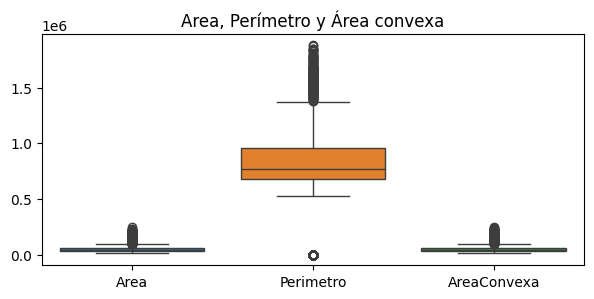

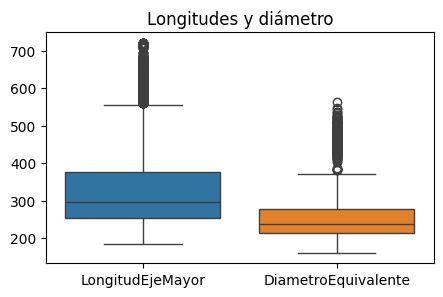

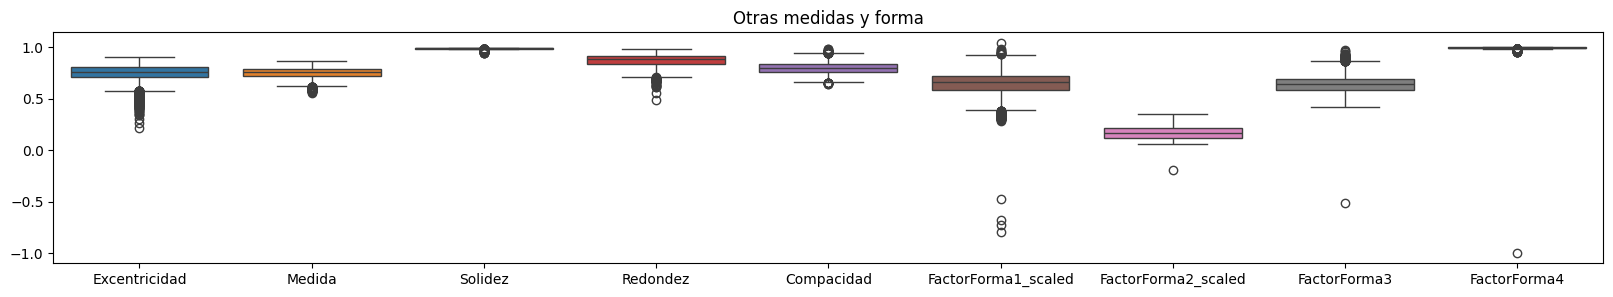

In [240]:
# Visualización de todas las variables numéricas

# graficamos por variables con dimensiones similares
# Area, Perímetro, Área convexa
fig=plt.figure(figsize=(7,3))
ax = sns.boxplot(data=df[["Area", "Perimetro", "AreaConvexa"]], orient="v")
plt.title("Area, Perímetro y Área convexa")
plt.show()

# LongitudEjes, Diámetros
fig=plt.figure(figsize=(5,3))
ax2 = sns.boxplot(data=df[["LongitudEjeMayor", "LongitudEjeMayor", "DiametroEquivalente"]], orient="v")
plt.title("Longitudes y diámetro")
plt.show()

# otras medidas y forma
df["FactorForma1_scaled"] = df["FactorForma1"]*100
df["FactorForma2_scaled"] = df["FactorForma2"]*100
fig=plt.figure(figsize=(20,3))
ax3 = sns.boxplot(data=df[["Excentricidad", "Medida", "Solidez", "Redondez", "Compacidad", "FactorForma1_scaled", "FactorForma2_scaled", "FactorForma3", "FactorForma4"]], orient="v")
plt.title("Otras medidas y forma")
plt.show()

Más aún, el FactorForma1,2,3 y 4, con la infromación del diccionario es imposible saber si debería ser mayor a 0. Sin embargo, sabiendo que son medidas gemoetricas derivadas de las otras medidas, es posible que también deban ser positivas, entonces exploramos esta posibilidad.

In [241]:
(df["FactorForma1"] < 0).sum()

np.int64(4)

In [242]:
(df["FactorForma2"] < 0).sum()

np.int64(1)

In [243]:
(df["FactorForma3"] < 0).sum()

np.int64(1)

In [244]:
(df["FactorForma4"] < 0).sum()

np.int64(1)

In [245]:
df = df[df["FactorForma1"] >= 0]
df = df[df["FactorForma2"] >= 0]
df = df[df["FactorForma3"] >= 0]
df = df[df["FactorForma4"] >= 0]

In [246]:
df.isnull().sum()

ï»¿ID                    0
Area                     0
Perimetro                0
LongitudEjeMayor         0
LongitudEjeMenor         0
RelacionAspecto        148
Excentricidad            0
AreaConvexa              0
DiametroEquivalente      0
Medida                   0
Solidez                  0
Redondez                 0
Compacidad               0
FactorForma1             0
FactorForma2             0
FactorForma3             0
FactorForma4             0
DefectoVisible         964
MetodoSecado           189
FactorForma1_scaled      0
FactorForma2_scaled      0
dtype: int64

De los datos vemos que hay 3 columnas problematicas: RelacionAspecto, DefectoVisible y MetodoSecado. Como defectoVisibles tiene tantos valores vacíos es mejor simplemente dehacernos de toda la columna. Para las otras dos podemos hacer una inputacion de datos con la media de la columna.También quitamos el id, que no aporta información para la clasificación.

In [247]:
df = df.drop(columns=["DefectoVisible","ï»¿ID"])

## Col categóricas

In [248]:
df

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,RelacionAspecto,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,Compacidad,FactorForma1,FactorForma2,FactorForma3,FactorForma4,MetodoSecado,FactorForma1_scaled,FactorForma2_scaled
2,59965,994266.00,389.088529,197.967275,Alargado,0.860886,60910.0,276.314692,0.661581,0.984485,0.762259,0.710159,0.006489,0.001018,0.504326,0.991211,Natural,0.648859,0.101801
4,39324,737773.00,262.520242,191.176858,Alargado,0.685326,39758.0,223.760747,0.775392,0.989084,0.907867,0.852356,0.006676,0.002174,0.726511,0.997630,Lavado,0.667583,0.217355
10,39948,731068.00,244.969135,207.964148,Redondeado,0.528489,40386.0,225.529096,0.772032,0.989155,0.939268,0.920643,0.006132,0.002717,0.847583,0.998402,Lavado,0.613220,0.271745
11,39392,746.64,265.915971,189.144664,Alargado,0.702894,39836.0,223.954130,0.725291,0.988854,0.887964,0.842199,0.006751,0.002095,0.709299,0.997194,Natural,0.675051,0.209496
18,46757,829953.00,307.901337,194.605988,Alargado,0.774936,47292.0,243.993568,0.720169,0.988687,0.853001,0.792441,0.006585,0.001602,0.627962,0.993548,Natural,0.658514,0.160181
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14284,29882,649082.00,247.427847,154.779257,Alargado,0.780182,30213.0,195.056259,0.671430,0.989044,0.891293,0.788336,0.008280,0.001973,0.621474,0.993478,Natural,0.828016,0.197271
14285,32384,657952.00,238.548336,173.086148,Alargado,0.688137,32711.0,203.058094,0.755841,0.990003,0.940052,0.851224,0.007366,0.002386,0.724582,0.998624,Lavado,0.736624,0.238562
14286,83266,1117778.00,448.473710,237.747098,Alargado,0.847920,84030.0,325.603384,0.797239,0.990908,0.837465,0.726026,0.005386,0.000923,0.527113,0.994319,Lavado,0.538604,0.092312
14287,39857,755392.00,283.623668,179.430885,Alargado,0.774448,40330.0,225.272077,0.692154,0.988272,0.877748,0.794264,0.007116,0.001747,0.630855,0.997183,Natural,0.711603,0.174694


Encontramos los valores únicos de las columnas categóricas y encontramos categorías equivalentes para que podamos unificarlas.

In [249]:
df["MetodoSecado"].unique()

array(['Natural', 'Lavado', 'lavado', nan, 'natural', 'Honey', 'honey'],
      dtype=object)

In [250]:
df["RelacionAspecto"].unique()

array(['Alargado', 'Redondeado', 'alargado', nan, 'redondeado'],
      dtype=object)

Hay un error donde la misma cateogría está dividida en 2 por el uso de mayusculas.

In [251]:
df["MetodoSecado"] = df["MetodoSecado"].str.lower()
df["RelacionAspecto"] = df["RelacionAspecto"].str.lower()

In [252]:
imputer = SimpleImputer(strategy="most_frequent")
df[["MetodoSecado"]] = imputer.fit_transform(df[["MetodoSecado"]])
df[["RelacionAspecto"]] = imputer.fit_transform(df[["RelacionAspecto"]])

In [253]:
df.isnull().sum()

Area                   0
Perimetro              0
LongitudEjeMayor       0
LongitudEjeMenor       0
RelacionAspecto        0
Excentricidad          0
AreaConvexa            0
DiametroEquivalente    0
Medida                 0
Solidez                0
Redondez               0
Compacidad             0
FactorForma1           0
FactorForma2           0
FactorForma3           0
FactorForma4           0
MetodoSecado           0
FactorForma1_scaled    0
FactorForma2_scaled    0
dtype: int64

In [254]:
df["MetodoSecado"].unique()

array(['natural', 'lavado', 'honey'], dtype=object)

In [255]:
df["RelacionAspecto"].unique()

array(['alargado', 'redondeado'], dtype=object)

Ahora hacemos la transformación de categóricas a numéricas a través de one-hot encoding

In [256]:
df = pd.get_dummies(df, columns=['MetodoSecado','RelacionAspecto'])

In [257]:
df

,Area,Perimetro,LongitudEjeMayor,LongitudEjeMenor,Excentricidad,AreaConvexa,DiametroEquivalente,Medida,Solidez,Redondez,...,FactorForma2,FactorForma3,FactorForma4,FactorForma1_scaled,FactorForma2_scaled,MetodoSecado_honey,MetodoSecado_lavado,MetodoSecado_natural,RelacionAspecto_alargado,RelacionAspecto_redondeado
2,59965,994266.00,389.088529,197.967275,0.860886,60910.0,276.314692,0.661581,0.984485,0.762259,...,0.001018,0.504326,0.991211,0.648859,0.101801,False,False,True,True,False
4,39324,737773.00,262.520242,191.176858,0.685326,39758.0,223.760747,0.775392,0.989084,0.907867,...,0.002174,0.726511,0.997630,0.667583,0.217355,False,True,False,True,False
10,39948,731068.00,244.969135,207.964148,0.528489,40386.0,225.529096,0.772032,0.989155,0.939268,...,0.002717,0.847583,0.998402,0.613220,0.271745,False,True,False,False,True
11,39392,746.64,265.915971,189.144664,0.702894,39836.0,223.954130,0.725291,0.988854,0.887964,...,0.002095,0.709299,0.997194,0.675051,0.209496,False,False,True,True,False
18,46757,829953.00,307.901337,194.605988,0.774936,47292.0,243.993568,0.720169,0.988687,0.853001,...,0.001602,0.627962,0.993548,0.658514,0.160181,False,False,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14284,29882,649082.00,247.427847,154.779257,0.780182,30213.0,195.056259,0.671430,0.989044,0.891293,...,0.001973,0.621474,0.993478,0.828016,0.197271,False,False,True,True,False
14285,32384,657952.00,238.548336,173.086148,0.688137,32711.0,203.058094,0.755841,0.990003,0.940052,...,0.002386,0.724582,0.998624,0.736624,0.238562,False,True,False,True,False
14286,83266,1117778.00,448.473710,237.747098,0.847920,84030.0,325.603384,0.797239,0.990908,0.837465,...,0.000923,0.527113,0.994319,0.538604,0.092312,False,True,False,True,False
14287,39857,755392.00,283.623668,179.430885,0.774448,40330.0,225.272077,0.692154,0.988272,0.877748,...,0.001747,0.630855,0.997183,0.711603,0.174694,False,False,True,True,False


Escalamos las columnas, lo cual es muy importante en este tipo de algoritmos que se basa en distancia.

In [258]:
num_cols = df.select_dtypes(include=['float64','int64']).columns

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df_before_drop = df[num_cols] 

Obtenemos la matriz de correlación:

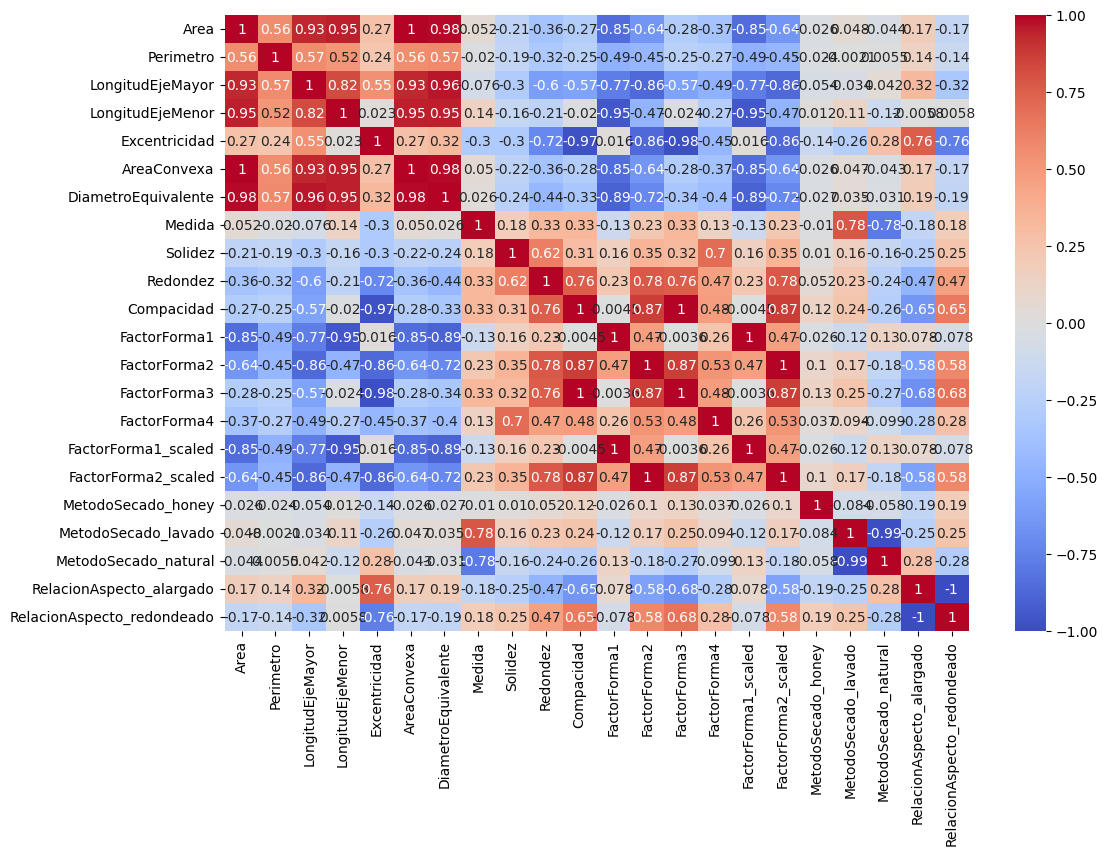

In [259]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

Veamos que hay unas columnas que están altamente correlacionadas, por lo tanto no es un buena practica mantenerlas. Primero, es un error tener ambos RelacionAspecto_alargado y RelacionAspecto_redondeado dado que están completamente correlacionadas. Similarmente, MetodoSecado_lavado y MetodoSecado_natural están fuertemente correlacionadas. Asimismo, FactorForma1 y 2, están correlacionados fuertemente con su versión escalada y con otros factores como LongitudEjeMenor, AreaConvexa, DiametroEquivalente,LongitudEjeMayor, Area y Excentricidad. Compacidad también está fuertemente correlacionada con otras variables.

In [260]:
df = df.drop(columns=["Compacidad","RelacionAspecto_alargado","MetodoSecado_natural","AreaConvexa","LongitudEjeMayor","LongitudEjeMenor","FactorForma1_scaled","FactorForma2_scaled","Excentricidad","DiametroEquivalente"])
df.dtypes

Area                          float64
Perimetro                     float64
Medida                        float64
Solidez                       float64
Redondez                      float64
FactorForma1                  float64
FactorForma2                  float64
FactorForma3                  float64
FactorForma4                  float64
MetodoSecado_honey               bool
MetodoSecado_lavado              bool
RelacionAspecto_redondeado       bool
dtype: object

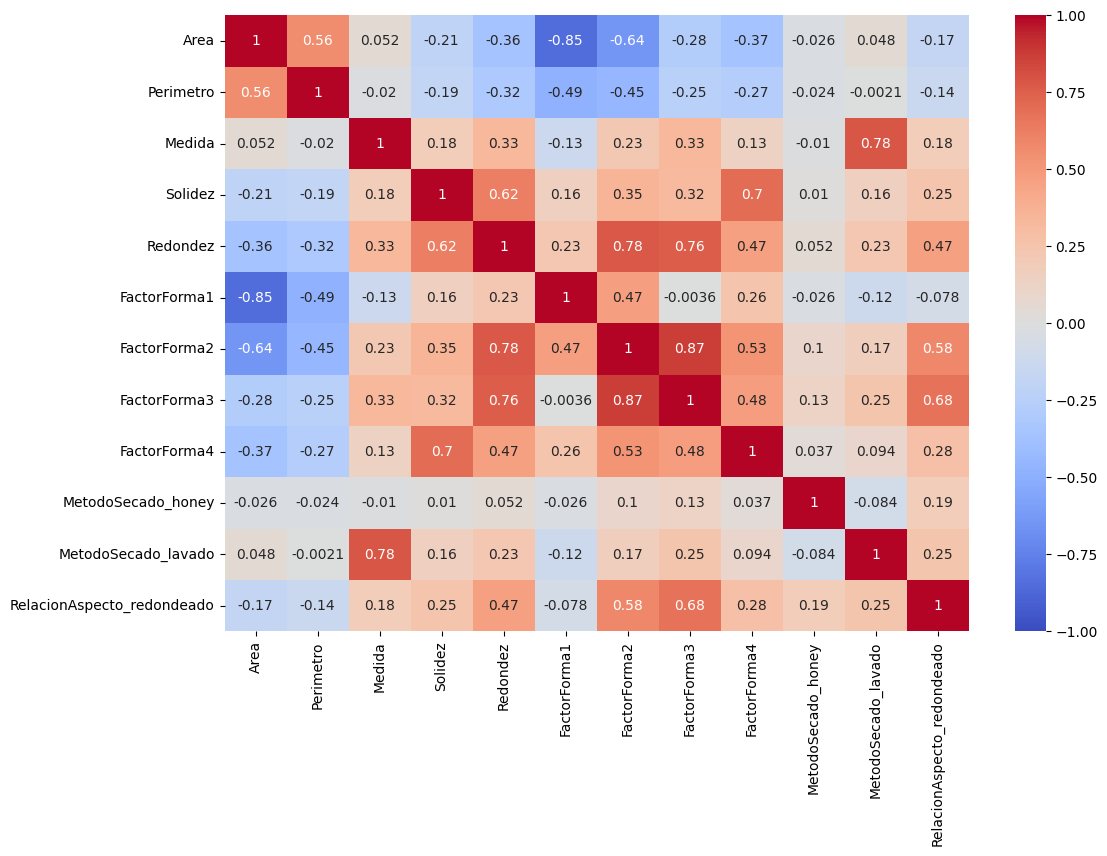

In [261]:
corr_matrix = df.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.show()

A pesar de que todavía tenemos algunas correlaciones altas. Ya nos quedamos con variables con correlaciones de menos de 0.9.

# 2. Modelos
## A. K-Means - Juan Felipe Camelo

k=2, silhouette=0.328
k=3, silhouette=0.273
k=4, silhouette=0.236
k=5, silhouette=0.253
k=6, silhouette=0.262
k=7, silhouette=0.256
k=8, silhouette=0.267
k=9, silhouette=0.265


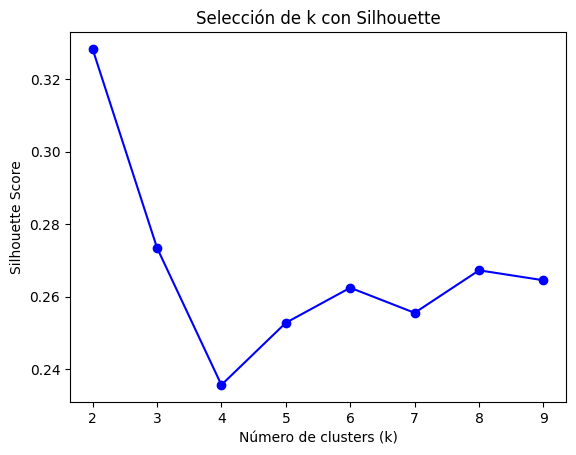

In [262]:
X = df.values  # convert to numpy

silhouette_scores = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)
    score = silhouette_score(X, labels)
    silhouette_scores.append(score)
    print(f"k={k}, silhouette={score:.3f}")

plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Silhouette Score")
plt.title("Selección de k con Silhouette")
plt.show()

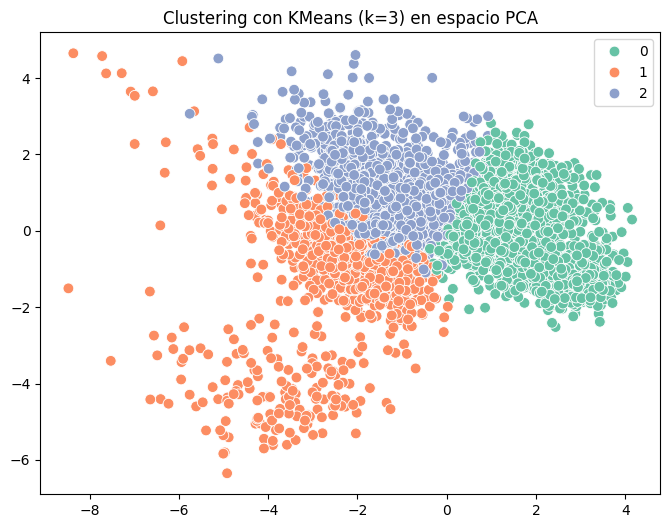

In [263]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

best_k = 3  # poenmos el codo de la gráfica
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels, palette="Set2", s=60)
plt.title(f"Clustering con KMeans (k={best_k}) en espacio PCA")
plt.show()


## B. DBSCAN - Mauricio Urrego Vásquez

Este es un algoritmo de clustering basado en densidad que agrupa puntos que están densamente conectados entre sí y separa los que están en regiones de baja densidad, marcándolos como outliers. No requiere especificar el número de clusters de antemano, sino dos parámetros: `eps`, que define el radio de vecindad, y `min_samples`, que indica el número mínimo de puntos cercanos necesarios para formar un cluster. Este algortimo es útil para detectar clusters de formas arbitrarias y manejar datos con ruido.


### Preparación de datos

Ya una vez hecho la preparación de datos para K-Means esta nos servirá para la implementación del algoritmo DBSCAN. Tanto K-Means como DBSCAN se basan en distancias, por lo que necesitan datos numéricos en escalas comparables, lo cual ya se realizó.

### Búsqueda hiperparámetros

DBSCAN necesita un radio de vecindad (`eps`) y un mínimo de puntos (`min_samples`). Para `min_samples`, se utiliza como regla básica utilizar el número de dimensiones + 1. Esto lo hacemos, ya que para que un punto sea considerado parte de un cluster, necesita suficientes vecinos en un espacio de D dimensiones, con D+1 nos aseguramos que la bola de radio épsilo no sea "vacía". En nuestro caso, entonces, utilizaremos a 13).

Un método común para elegir `eps` es graficar la distancia al k-ésimo vecino más cercano (donde k es `min_samples`) y buscar el codo en la curva. Graficando la distancia al `min_points` -ésimo vecino más cercano para cada punto de datos del conjunto. Ordenamos estas distancias y las graficamos. La lógica es que los puntos dentro de un clúster denso tendrán una distancia muy pequeña a su k-ésimo vecino, mientras que los puntos de ruido estarán mucho más lejos (la curva crece rápidamente). El valor óptimo se elige en el codo de la curva, ya que representa la distancia donde la densidad cambia drásticamente

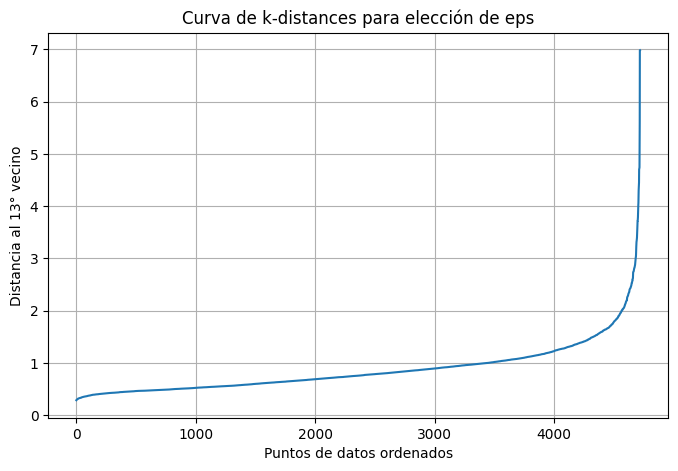

In [264]:
from sklearn.neighbors import NearestNeighbors

# estimación de min_samples D+1
min_samples = 13

# ajustar NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(X)
distances, indices = neighbors_fit.kneighbors(X)

# ordenar distancias al k-ésimo vecino
distances = np.sort(distances[:, -1])

# gráfico de k-distances
plt.figure(figsize=(8,5))
plt.plot(distances)
plt.xlabel(f"Puntos de datos ordenados")
plt.ylabel(f"Distancia al {min_samples}° vecino")
plt.title("Curva de k-distances para elección de eps")
plt.grid(True)
plt.show()


De la gráfica se puede observar que el codo está alrededor del dato 4500, lo que corresponde a una distancia de aprox. 1.5-1.6. Ahora podemos implementar el algoritmo:

### Modelo

In [265]:
from sklearn.cluster import DBSCAN

# definimos hiperparámetros
eps_value = 1.6     # codo del gráfico
min_samples = 13    # Ajustado previamente

# crear e implementar el modelo
dbscan = DBSCAN(eps=eps_value, min_samples=min_samples)
dbscan_labels = dbscan.fit_predict(X)

# agregamos etiquetas al dataframe
df['DBSCAN_cluster'] = dbscan_labels
df['DBSCAN_cluster'].value_counts()

DBSCAN_cluster
 0    4169
 1     412
-1     138
Name: count, dtype: int64

Los puntos marcados como -1 son los considerados como outliers.

### Resultados

Graficamos la cantidad de datos clasificados para cada cluster

C:\Users\mauri\AppData\Local\Temp\ipykernel_13516\2100965011.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts.index, y=counts.values, palette='viridis')


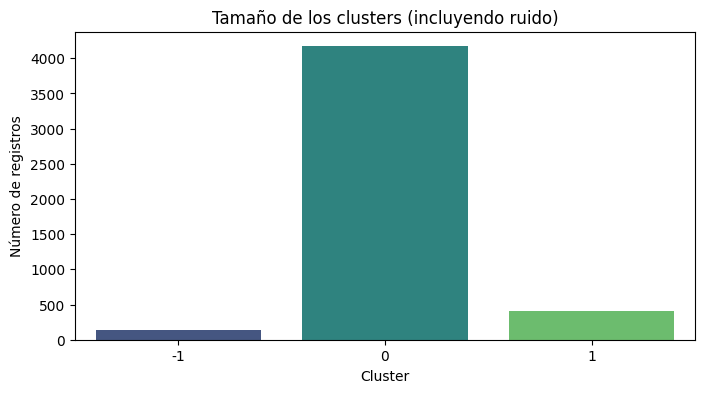

In [266]:
# Contamos registros en cada cluster
counts = df['DBSCAN_cluster'].value_counts().sort_index()

plt.figure(figsize=(8,4))
sns.barplot(x=counts.index, y=counts.values, palette='viridis')
plt.xlabel('Cluster')
plt.ylabel('Número de registros')
plt.title('Tamaño de los clusters (incluyendo ruido)')
plt.show()

DBSCAN identificó un gran grupo denso, el cluster 0, que concentra la mayor parte de los granos (4169 registros) y que parece representar el perfil más común en el conjunto de datos. El cluster 1, mucho más pequeño, agrupa 412 registros y refleja la existencia de un subgrupo de granos con características particulares que los diferencian del patrón principal. 138 registros fueron etiquetados como -1, lo que indica que DBSCAN los considera ruido.

Ahora, graficamos combinaciones de variables y gráficas de densidad para identificar los clusters.

C:\Users\mauri\AppData\Local\Temp\ipykernel_13516\757283190.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pair['DBSCAN_cluster'] = df_pair['DBSCAN_cluster'].astype(str)


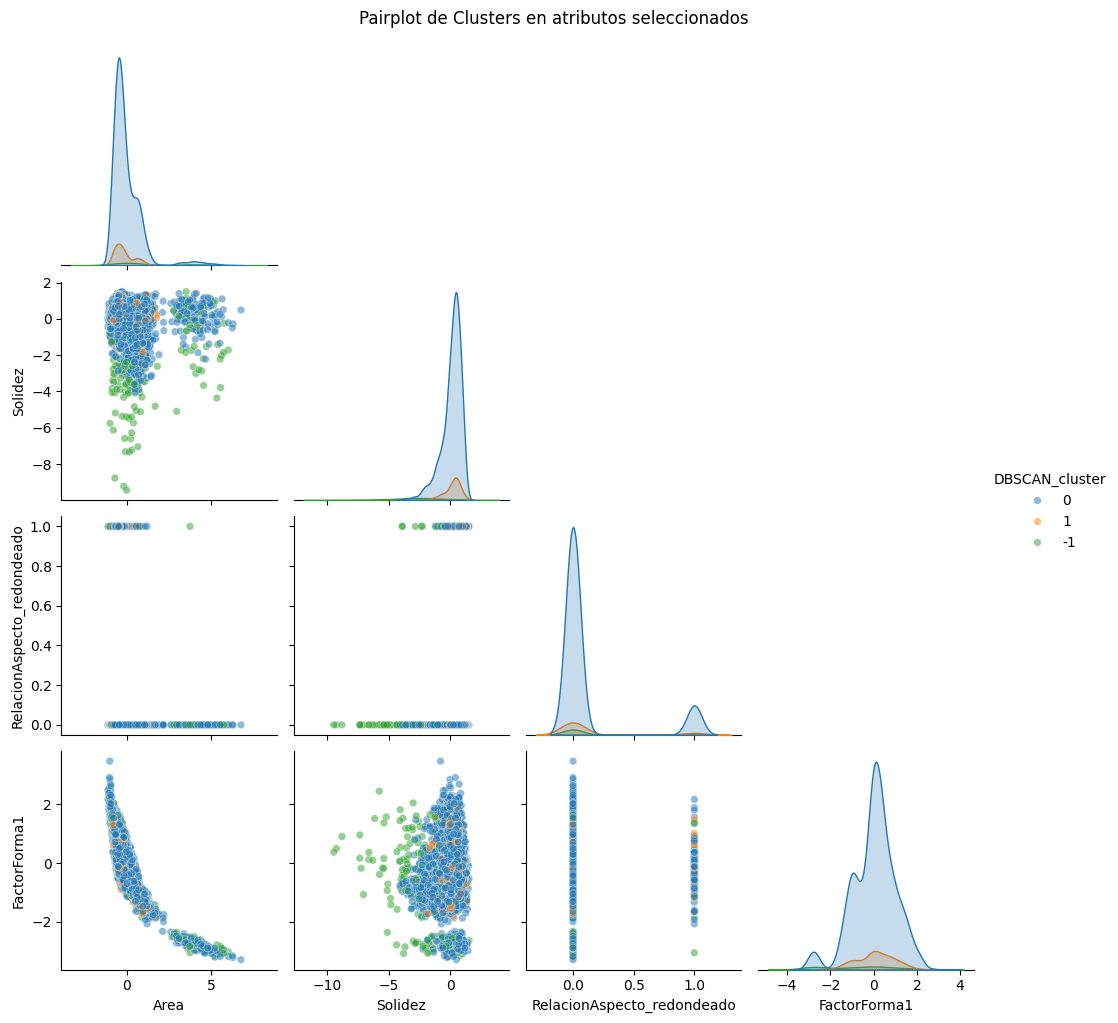

In [271]:
# seleccionar algunas variables importantes
features = ['Area', 'Solidez', 'RelacionAspecto_redondeado', 'FactorForma1']

# crear un nuevo DataFrame solo con las variables seleccionadas
df_pair = df[features + ['DBSCAN_cluster']]

# Convertir Cluster a string para mejor coloración
df_pair['DBSCAN_cluster'] = df_pair['DBSCAN_cluster'].astype(str)

# Generar el pairplot
sns.pairplot(df_pair, hue='DBSCAN_cluster', diag_kind='kde', corner=True,
             plot_kws={'alpha':0.5, 's':30})
plt.suptitle("Pairplot de Clusters en atributos seleccionados", y=1.02)
plt.show()

Los clusters 0 y 1 no están muy claramente separados cuando se proyectan en las combinaciones. Solidez y relacion_aspecto parecen ser dos atributos  que sí caracterizan a los clusters. Se observan diferencias leves en las distribuciones, especialmente en variables como Solidez y FactorForma1, aunque los clusters comparten amplias regiones del espacio de atributos. Asimismo, las gráficas de la diagonal muestran que comparten picos en regiones similares.

Ahora, obtenemos algunas características de los clústers.

In [272]:
#columnas que entrenaron el modelo
num_cols_model = [
    'Area','Perimetro','Medida','Solidez','Redondez',
    'FactorForma1','FactorForma2','FactorForma3','FactorForma4'
]

# invertimos el escalado de todo el df_before_drop
df_original_all = pd.DataFrame(
    scaler.inverse_transform(df_before_drop),
    columns=df_before_drop.columns,
    index=df_before_drop.index
)

# Extraemos solo las columnas numéricas que interesan al modelo
df_original = df_original_all[num_cols_model].copy()

# Agregamos las columnas categóricas y la etiqueta de cluster desde el df final
df_original['MetodoSecado_honey'] = df['MetodoSecado_honey'].values
df_original['MetodoSecado_lavado'] = df['MetodoSecado_lavado'].values
df_original['RelacionAspecto_redondeado'] = df['RelacionAspecto_redondeado'].values
df_original['DBSCAN_cluster'] = df['DBSCAN_cluster'].values

# filtramos para quitar el ruido (etiqueta -1)
df_no_noise = df_original[df_original['DBSCAN_cluster'] != -1]

# ahora podemos calcular las características de los clusters
cluster_stats = df_original.groupby('DBSCAN_cluster').agg({
    **{col: ['mean','std','min','max'] for col in num_cols_model},
    'MetodoSecado_honey': 'mean',
    'MetodoSecado_lavado': 'mean',
    'RelacionAspecto_redondeado': 'mean'
})

print(cluster_stats)
cluster_stats

                        Area                                       Perimetro  \
                        mean           std      min       max           mean   
DBSCAN_cluster                                                                 
-1              90517.586957  59043.607166  23510.0  226687.0  666614.858551   
 0              52044.349244  27402.966074  20420.0  248424.0  847810.086112   
 1              48156.208738  16770.401775  22721.0  103899.0     822.431262   

                                                        Medida            ...  \
                          std        min         max      mean       std  ...   
DBSCAN_cluster                                                            ...   
-1              618157.460192     558.79  1849699.00  0.732981  0.057637  ...   
 0              204501.387117  524932.00  1884557.00  0.751123  0.047862  ...   
 1                 158.032401     553.60     1297.77  0.751832  0.048311  ...   

               FactorForma3     

Area                                       Perimetro  \
                        mean           std      min       max           mean   
DBSCAN_cluster                                                                 
-1              90517.586957  59043.607166  23510.0  226687.0  666614.858551   
 0              52044.349244  27402.966074  20420.0  248424.0  847810.086112   
 1              48156.208738  16770.401775  22721.0  103899.0     822.431262   

                                                        Medida            ...  \
                          std        min         max      mean       std  ...   
DBSCAN_cluster                                                            ...   
-1              618157.460192     558.79  1849699.00  0.732981  0.057637  ...   
 0              204501.387117  524932.00  1884557.00  0.751123  0.047862  ...   
 1                 158.032401     553.60     1297.77  0.751832  0.048311  ...   

               FactorForma3                     FactorForma4            \
                        std       min       max         mean       std   
DBSCAN_cluster                                                           
-1                 0.099287  0.434193  0.899966     0.985055  0.010837   
 0                 0.098384  0.416499  0.974767     0.995367  0.003624   
 1                 0.097070  0.445379  0.963560     0.995954  0.002703   

                                   MetodoSecado_honey MetodoSecado_lavado  \
                     min       max               mean                mean   
DBSCAN_cluster                                                              
-1              0.951239  0.999134           0.021739            0.434783   
 0              0.974075  0.999709           0.004318            0.595107   
 1              0.985066  0.999535           0.004854            0.606796   

               RelacionAspecto_redondeado  
                                     mean  
DBSCAN_cluster                             
-1                               0.057971  
 0                               0.124011  
 1                               0.133495  

[3 rows x 39 columns]

El cluster 0 representa granos con valores de área y perímetro intermedios-altos, alta solidez (alrededor de 0.75) y una proporción moderada de granos redondeados. Por otro lado, el cluster 1 agrupa granos con valores de área y perímetro algo menores que los del cluster principal, pero con una solidez y relación de aspecto similares; además, presenta una variabilidad ligeramente menor en atributos derivados como FactorForma4.

### Evaluación:

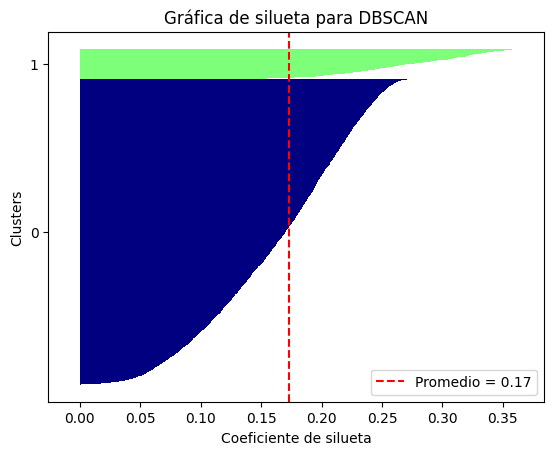

Coeficiente de silueta promedio (excluyendo ruido): 0.173


In [269]:
import matplotlib.cm as cm
from sklearn.metrics import silhouette_samples, silhouette_score

def plot_silhouette(data, labels,
                    ylabel='Clusters',
                    xlabel='Coeficiente de silueta',
                    title='Gráfica de silueta para DBSCAN'):

    # Filtramos solo puntos que pertenecen a clusters (excluyendo ruido)
    mask = labels != -1
    data_clustered = data[mask]
    labels_clustered = labels[mask]

    cluster_labels = np.unique(labels_clustered)
    n_clusters = cluster_labels.shape[0]

    silhouette_vals = silhouette_samples(data_clustered,
                                         labels_clustered,
                                         metric='euclidean')

    y_lower, y_upper = 0, 0
    yticks = []

    for i, c in enumerate(cluster_labels):
        c_sil_vals = silhouette_vals[labels_clustered == c]
        c_sil_vals.sort()

        y_upper += len(c_sil_vals)
        color = cm.jet(float(i) / n_clusters)
        plt.barh(range(y_lower, y_upper),
                 c_sil_vals,
                 height=1.0,
                 edgecolor='none',
                 color=color)
        yticks.append((y_lower + y_upper) / 2.)
        y_lower += len(c_sil_vals)

    # Promedio de silueta
    silhouette_avg = silhouette_score(data_clustered, labels_clustered)
    plt.axvline(silhouette_avg, color="red", linestyle="--", label=f'Promedio = {silhouette_avg:.2f}')

    plt.yticks(yticks, cluster_labels)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.legend()
    plt.show()

    print(f'Coeficiente de silueta promedio (excluyendo ruido): {silhouette_avg:.3f}')


plot_silhouette(X, dbscan_labels)

La evaluación con el coeficiente de silueta muestra un valor promedio de 0.173, lo cual es bajo y evidencia que los clusters no están claramente definidos. Esto tiene relación con los resultados del pairplot, ya que refleja una superposición significativa entre los clusters y una débil separación entre ellos. En la gráfica de silueta, muchos puntos se encuentran cerca de los límites entre grupos, con valores de silueta cercanos a cero, lo que indica ambigüedad en su asignación. Esto sugiere que los datos no presenta fronteras claramente delimitadas, lo que podría mejorarse probando otros algoritmos alternativos.

## C. DBSCAN - Hernán Ramírez

# 3. Modelo recomendado